# Identifying Fraudulent Activities

* Goal 1: For each user, determine her country based on the numeric IP address.

* Goal 2: Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

* Goal 3: Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?

* Goal 4: Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

## Table of Content

- Packages and Data
- 1 - Data Exploration
- 2 - Analysis and Discussion

## Packages and Data

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
col_type = {'user_id': str}
fraud = pd.read_csv('Fraud_Data.csv', dtype=col_type, parse_dates=['signup_time', 'purchase_time'])
fraud['ip_address'] = fraud['ip_address'].astype(int)

col_type = {'lower_bound_ip_address': int}
ip_address = pd.read_csv('IpAddress_to_Country.csv', dtype=col_type)

In [15]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  object        
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  int64         
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(5)
memory usage: 12.7+ MB


In [16]:
ip_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   lower_bound_ip_address  138846 non-null  int64 
 1   upper_bound_ip_address  138846 non-null  int64 
 2   country                 138846 non-null  object
dtypes: int64(2), object(1)
memory usage: 3.2+ MB


In [20]:
def decide_country(x):
    try:
        return ip_address[(x >= ip_address['lower_bound_ip_address']) & (x <= ip_address['upper_bound_ip_address'])]['country'].values[0]
    except: 
        return 'Unknown'

fraud['country'] = fraud.apply(lambda x: decide_country(x['ip_address']), axis=1)

In [33]:
fraud['country'].value_counts()

United States     58049
Unknown           21966
China             12038
Japan              7306
United Kingdom     4490
                  ...  
Myanmar               1
Vanuatu               1
Dominica              1
Niger                 1
Guadeloupe            1
Name: country, Length: 182, dtype: int64

## Data Exploration

In [30]:
print(min(fraud['signup_time']), '~', max(fraud['signup_time']))
print(min(fraud['purchase_time']), '~', max(fraud['purchase_time']))

2015-01-01 00:00:42 ~ 2015-08-18 04:40:29
2015-01-01 00:00:44 ~ 2015-12-16 02:56:05


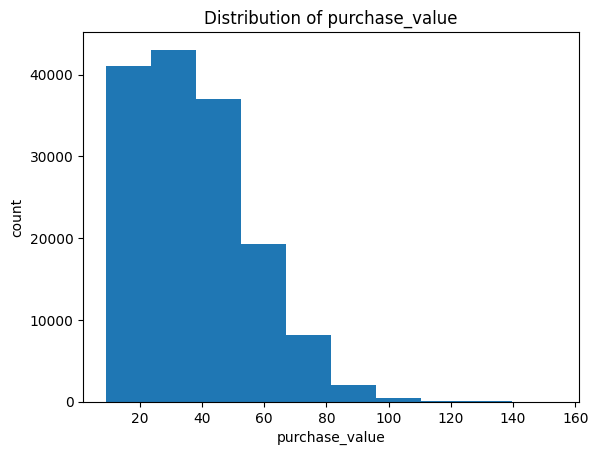

In [36]:
plt.hist(fraud['purchase_value'])
plt.title('Distribution of purchase_value')
plt.xlabel('purchase_value')
plt.ylabel('count')
plt.show()

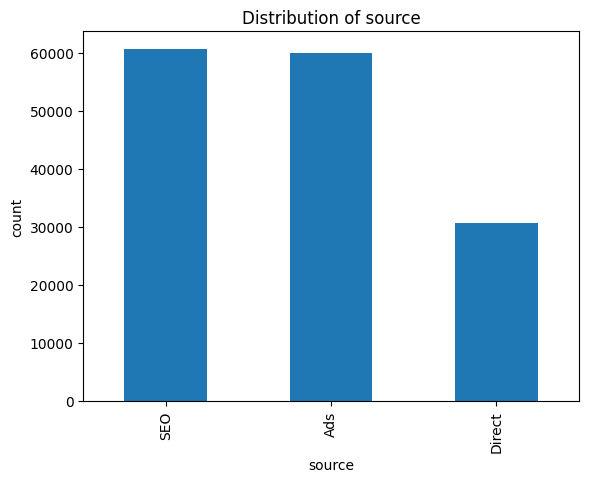

In [32]:
fraud['source'].value_counts().plot.bar()
plt.title('Distribution of source')
plt.xlabel('source')
plt.ylabel('count')
plt.show()

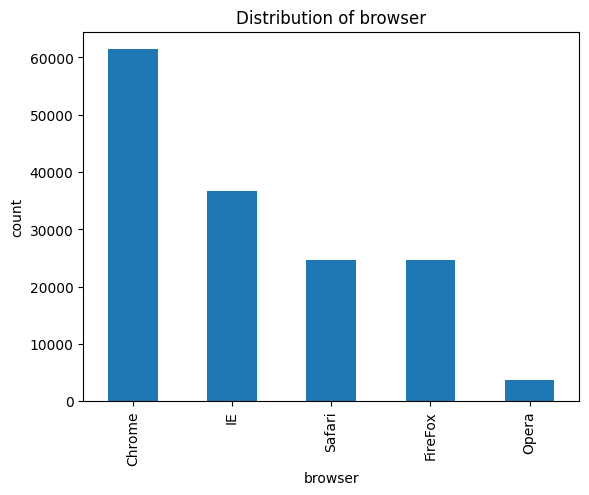

In [34]:
fraud['browser'].value_counts().plot.bar()
plt.title('Distribution of browser')
plt.xlabel('browser')
plt.ylabel('count')
plt.show()

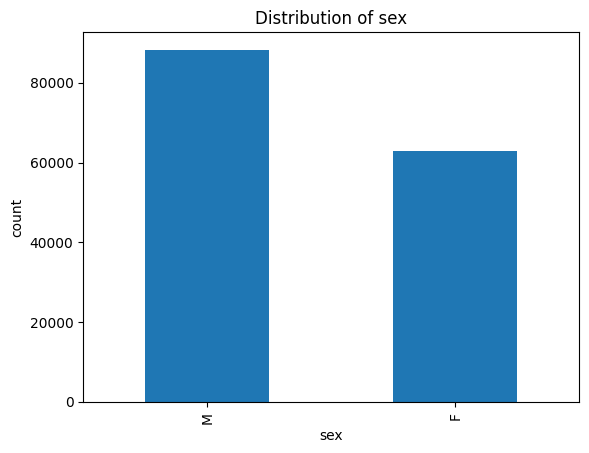

In [35]:
fraud['sex'].value_counts().plot.bar()
plt.title('Distribution of sex')
plt.xlabel('sex')
plt.ylabel('count')
plt.show()

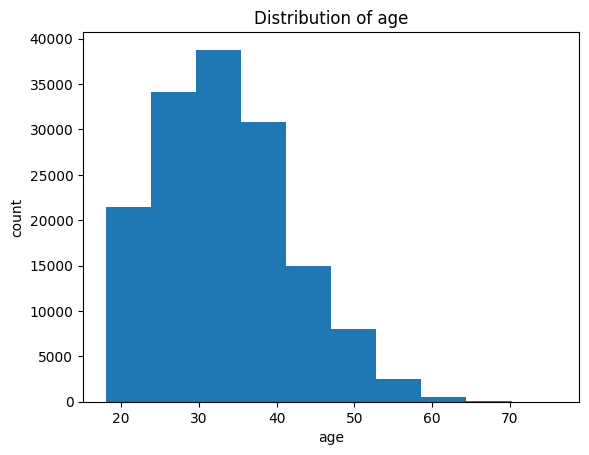

In [37]:
plt.hist(fraud['age'])
plt.title('Distribution of age')
plt.xlabel('age')
plt.ylabel('count')
plt.show()

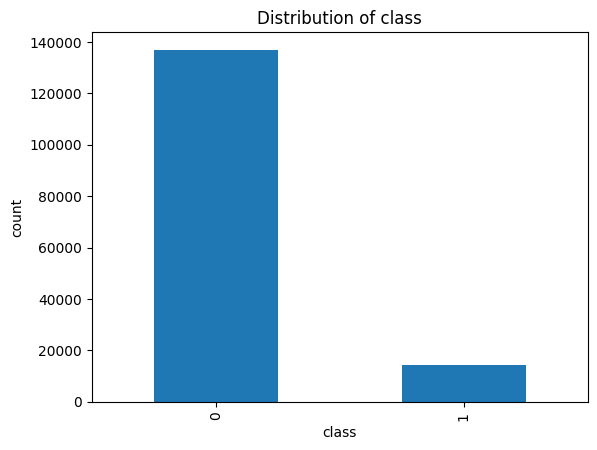

In [38]:
fraud['class'].value_counts().plot.bar()
plt.title('Distribution of class')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

In [45]:
fraud_one_hot = pd.get_dummies(fraud[['source', 'browser', 'sex']])
fraud_one_hot

,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,0,0,1,1,0,0,0,0,0,1
1,1,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,1,0,0,1
3,0,0,1,0,0,0,0,1,0,1
4,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
151107,0,0,1,1,0,0,0,0,0,1
151108,0,0,1,0,0,0,0,1,0,1
151109,0,0,1,0,0,1,0,0,1,0
151110,0,0,1,1,0,0,0,0,0,1


In [48]:
fraud_dataset = pd.concat([fraud[['purchase_value', 'age']], fraud_one_hot], axis=1)
fraud_dataset

,purchase_value,age,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,34,39,0,0,1,1,0,0,0,0,0,1
1,16,53,1,0,0,1,0,0,0,0,1,0
2,15,53,0,0,1,0,0,0,1,0,0,1
3,44,41,0,0,1,0,0,0,0,1,0,1
4,39,45,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
151107,43,28,0,0,1,1,0,0,0,0,0,1
151108,35,32,0,0,1,0,0,0,0,1,0,1
151109,40,26,0,0,1,0,0,1,0,0,1,0
151110,46,37,0,0,1,1,0,0,0,0,0,1


## Analysis and Discussion

In [ ]:
from sklearn.metrics import classification_report

In [50]:
X_train, X_test, y_train, y_test = train_test_split(fraud_dataset, fraud['class'], test_size=0.3, random_state=42)

In [70]:
weight_list = [
    {0: 1, 1: 1},
    {0: 1, 1: 10},
    {0: 1, 1: 100},
    {0: 1, 1: 1000},
    {0: 1, 1: 10000},
    {0: 1, 1: 100000},
]

for i in weight_list:
    clf = RandomForestClassifier(class_weight=i)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    print(i)
    print(classification_report(y_test, y_test_pred))

{0: 1, 1: 1}
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     41117
           1       0.59      0.49      0.54      4217

    accuracy                           0.92     45334
   macro avg       0.77      0.73      0.75     45334
weighted avg       0.92      0.92      0.92     45334

{0: 1, 1: 10}
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     41117
           1       0.39      0.59      0.47      4217

    accuracy                           0.87     45334
   macro avg       0.67      0.74      0.70     45334
weighted avg       0.90      0.87      0.89     45334

{0: 1, 1: 100}
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     41117
           1       0.31      0.61      0.41      4217

    accuracy                           0.84     45334
   macro avg       0.63      0.73      0.66     45334
weighted avg       0.90      0.8

3. Shap Value
4. Different UI for reviewing activites based on probability generated from model